#  Normalized weighted overlay approach based on GIS- based Multi Influencing Factor logic

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
# Load dataset
df = pd.read_csv(r'D:\CS\GitHub\Nuclear-Site-Selection\dam\dam.csv')
# Step 1: Define weights (you can adjust based on expert judgment)
weights = {
    'Avg_population': 0.30,
    'seismicity_numeric': 0.25,
    'nearest_highway_distance': 0.20,
    'distance_to_nearest_airport_km': 0.25
}
seismic_map = {
    'Seismic Zone-I': 1,
    'Seismic Zone-II': 2,
    'Seismic Zone-III': 3,
    'Seismic Zone-IV': 4
}


In [3]:
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

In [4]:
df.columns

Index(['dm_name', 'STATE_1', 'dm_lat', 'dm_long', 'dm_ses_zon', 'geometry',
       'Avg_population', 'nearest_airport', 'distance_to_nearest_airport_km',
       'nearest_highway_geometry', 'nearest_highway_distance',
       'nearest_highway'],
      dtype='object')

In [5]:
df['seismicity_numeric'] = df['dm_ses_zon'].map(seismic_map)

In [6]:
# Step 2: Normalize data using MinMaxScaler (lower values are better)
scaler = MinMaxScaler(feature_range=(0, 1))
columns_to_normalize = list(weights.keys())
df_normalized = pd.DataFrame(scaler.fit_transform(df[columns_to_normalize]), columns=columns_to_normalize)
# Step 3: Invert scores for suitability (since lower is better for all)
df_inverted = 1 - df_normalized

In [7]:
# Step 4: Apply weights
for col in weights:
    df_inverted[col] = df_inverted[col] * weights[col]
# Step 5: Compute final suitability score
df['suitability_score'] = df_inverted.sum(axis=1)
# Step 6: Classify into suitability categories (optional)
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
df['suitability_class'] = pd.cut(df['suitability_score'], bins=bins, labels=labels)


In [8]:
# Define color mapping for suitability classes
colors = {
        'Very Low': 'red',
        'Low': 'orange',
        'Moderate': 'yellow',
        'High': 'lightgreen',
        'Very High': 'blue'
}

# Add color column to dataframe based on suitability class
df['color'] = df['suitability_class'].map(colors)

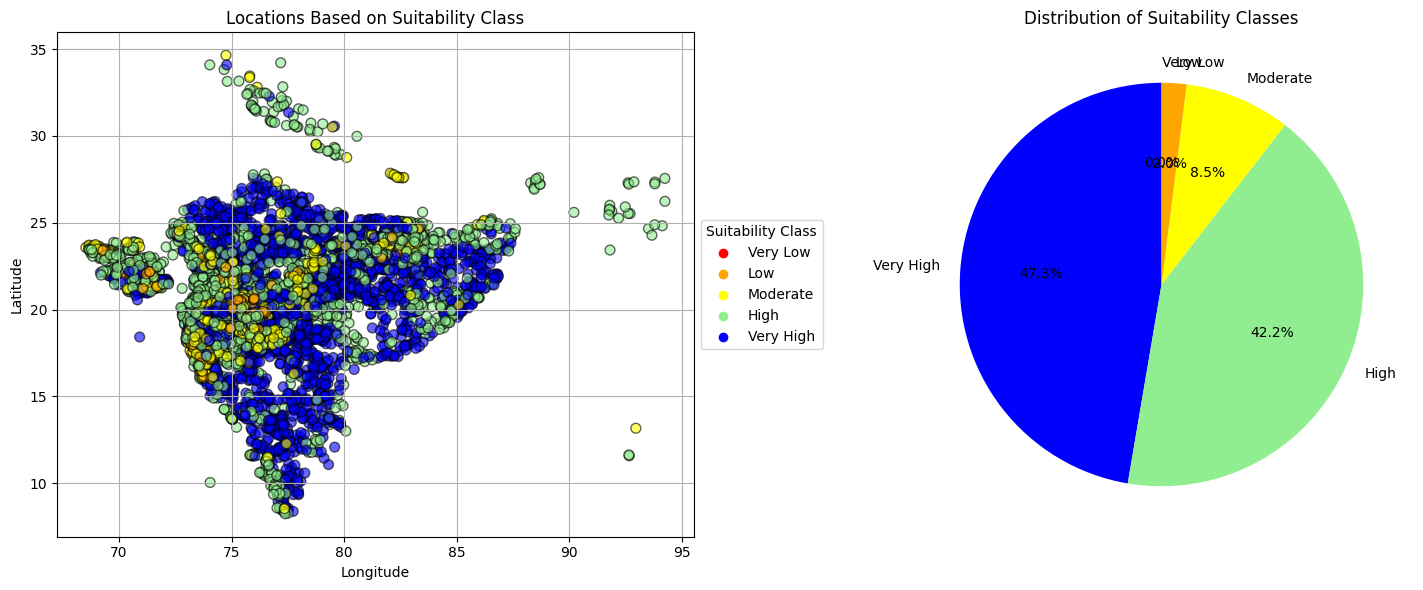

In [9]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
scatter = ax1.scatter(df['dm_long'], df['dm_lat'], c=df['color'], alpha=0.6, edgecolors='k', s=50)
ax1.set_title('Locations Based on Suitability Class')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True)

# Create legend for scatter plot

# Create legend elements
legend_elements = [plt.scatter([], [], c=color, label=label) for label, color in colors.items()]
ax1.legend(handles=legend_elements, title='Suitability Class', loc='center left', bbox_to_anchor=(1, 0.5))

# Pie chart
suitability_counts = df['suitability_class'].value_counts()
ax2.pie(suitability_counts, labels=suitability_counts.index, colors=[colors[x] for x in suitability_counts.index],
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Suitability Classes')

plt.tight_layout()
plt.show()

```markdown
# Applied Optimization for Dam Site Selection

This analysis employs a Multi-Criteria Decision Making (MCDM) approach to optimize dam site selection using the following criteria:

1. **Population Density** (30% weight)
    - Lower population density is preferred to minimize displacement

2. **Seismic Risk** (25% weight) 
    - Zones ranked from I (lowest risk) to IV (highest risk)
    - Lower seismic risk is preferred for structural stability

3. **Highway Accessibility** (20% weight)
    - Distance to nearest highway considered
    - Moderate proximity preferred for construction and maintenance

4. **Airport Distance** (25% weight)
    - Distance to nearest airport measured
    - Strategic positioning for emergency response

The optimization process involves:
- MinMax scaling of all criteria to [0,1] range
- Score inversion to align with "lower is better" principle
- Weighted sum calculation for final suitability score
- Classification into 5 categories: Very Low to Very High

Results show majority of sites fall in High (42.2%) and Very High (47.3%) suitability categories, indicating good overall site selection potential.
```

# Constraint Mapping/Boolean Logic

           dm_name       STATE_1     dm_lat    dm_long       dm_ses_zon  \
7        Galwa Dam     RAJASTHAN  25.890315  76.014779  Seismic Zone-II   
12     Bhopali Dam  CHHAtTISGARH  23.211656  83.282482  Seismic Zone-II   
14   Bhoramdeo Dam  CHHAtTISGARH  22.115533  81.150565  Seismic Zone-II   
15    Bhortola Dam  CHHAtTISGARH  20.594022  81.060532  Seismic Zone-II   
20  Bisrampuri Dam  CHHAtTISGARH  19.387538  81.837965  Seismic Zone-II   

                                        geometry  Avg_population  \
7        POINT (3608251.0505999997 4210896.2568)           207.0   
12  POINT (4329461.470200002 3918223.8790999986)           275.0   
14       POINT (4116463.1542000026 3795806.6765)           169.0   
15  POINT (4108594.6191999987 3630376.836599998)           288.0   
20   POINT (4189909.943099998 3499926.151900001)           115.0   

                           nearest_airport  distance_to_nearest_airport_km  \
7                       Kota Airport, kota                    

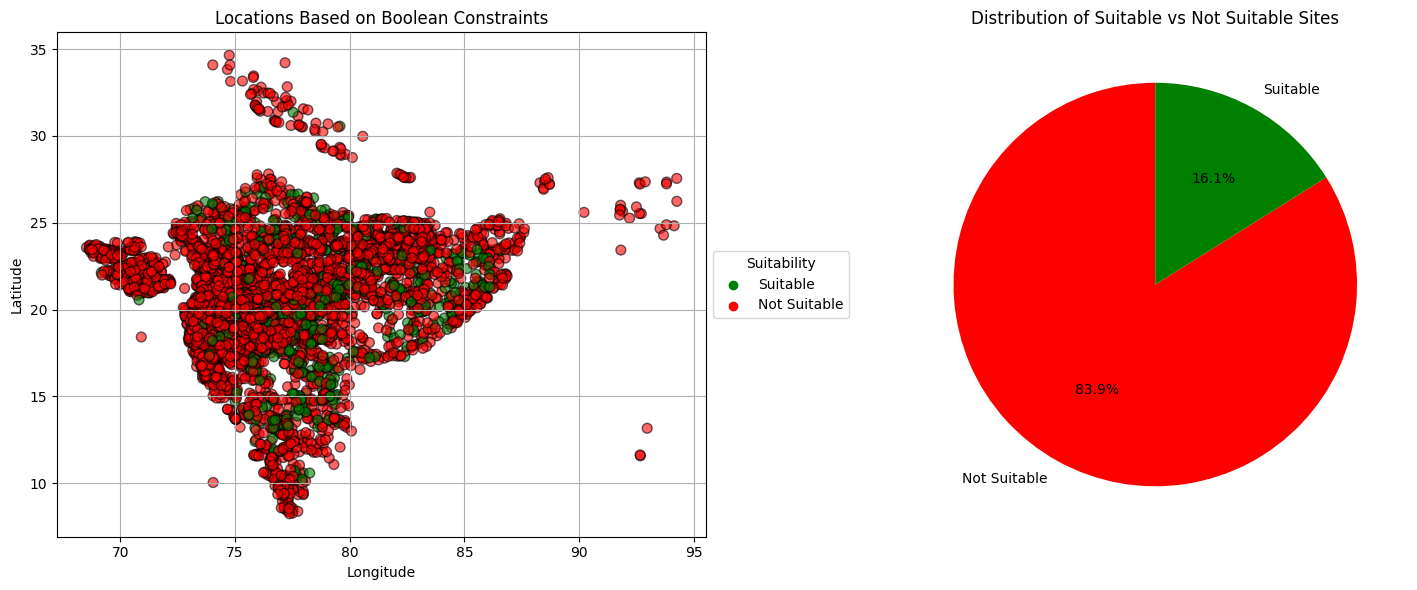

In [5]:

# Define constraints
# Adjust these thresholds based on your specific requirements
constraints = (
    (df['Avg_population'] <= 500) &  # Lower population density preferred
    (df['dm_ses_zon'].isin(['Seismic Zone-I', 'Seismic Zone-II'])) &  # Lower seismic risk zones
    (df['nearest_highway_distance'] <= 5) &  # Within 5 km of highways
    (df['distance_to_nearest_airport_km'] >= 10)   # At least 10 km away from airports
)

# Apply constraints
df['is_suitable'] = constraints

# Filter suitable locations
suitable_sites = df[df['is_suitable']]

# Save or display the results
suitable_sites.to_csv('suitable_sites.csv', index=False)
print(suitable_sites.head())
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Define colors for boolean results
boolean_colors = {True: 'green', False: 'red'}
df['bool_color'] = df['is_suitable'].map(boolean_colors)

# Scatter plot
scatter = ax1.scatter(df['dm_long'], df['dm_lat'], c=df['bool_color'], alpha=0.6, edgecolors='k', s=50)
ax1.set_title('Locations Based on Boolean Constraints')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True)

# Create legend elements for scatter plot
legend_elements = [plt.scatter([], [], c=color, label=label) 
                  for label, color in zip(['Suitable', 'Not Suitable'], ['green', 'red'])]
ax1.legend(handles=legend_elements, title='Suitability', loc='center left', bbox_to_anchor=(1, 0.5))

# Pie chart
bool_counts = df['is_suitable'].value_counts()
ax2.pie(bool_counts, labels=['Not Suitable', 'Suitable'], colors=['red', 'green'],
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Suitable vs Not Suitable Sites')

plt.tight_layout()
plt.show()

# Optimisation using Linear Programming

Top selected sites:
         dm_lat    dm_long
12   23.211656  83.282482
67   23.216710  74.313686
125  23.309619  74.325864
168  23.575335  83.733861
202  23.180761  74.271708


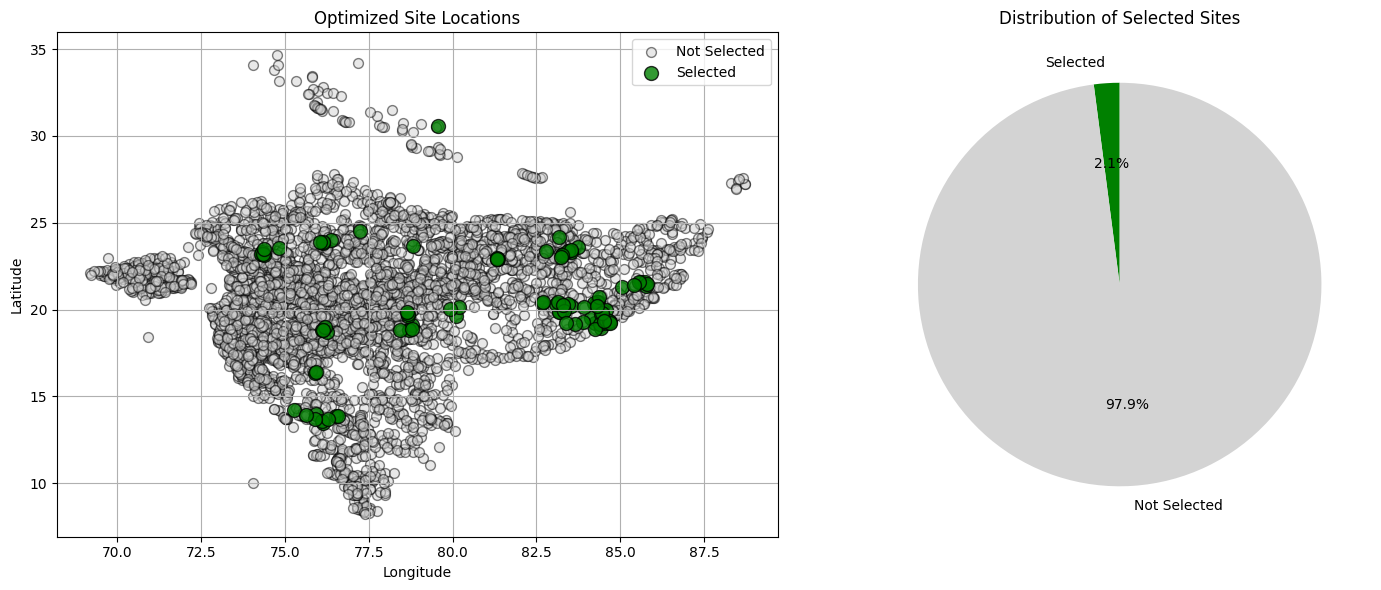

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pulp import LpMaximize, LpProblem, LpVariable, lpSum


# Clean data by removing rows with NaN or infinite values
df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=[
    'Avg_population', 'nearest_highway_distance',
    'distance_to_nearest_airport_km', 'seismicity_numeric'
])

# Normalize the criteria (lower is better, so subtract from 1)
df['norm_population'] = 1 - (df['Avg_population'] - df['Avg_population'].min()) / (df['Avg_population'].max() - df['Avg_population'].min())
df['norm_highway'] = 1 - (df['nearest_highway_distance'] - df['nearest_highway_distance'].min()) / (df['nearest_highway_distance'].max() - df['nearest_highway_distance'].min())
df['norm_airport'] = (df['distance_to_nearest_airport_km'] - df['distance_to_nearest_airport_km'].min()) / (df['distance_to_nearest_airport_km'].max() - df['distance_to_nearest_airport_km'].min())
df['norm_seismicity'] = 1 - (df['seismicity_numeric'] - df['seismicity_numeric'].min()) / (df['seismicity_numeric'].max() - df['seismicity_numeric'].min())

# Drop any row that has NaN after normalization
df = df.dropna(subset=['norm_population', 'norm_highway', 'norm_airport', 'norm_seismicity'])

# Define weights for each normalized criterion
weights = {
    'norm_population': 0.3,
    'norm_seismicity': 0.25,
    'norm_highway': 0.2,
    'norm_airport': 0.25
}

# Create the optimization problem
model = LpProblem(name="site-selection", sense=LpMaximize)

# Decision variables: binary indicator for each site
x = {i: LpVariable(name=f"x_{i}", cat='Binary') for i in df.index}

# Objective function: maximize weighted suitability score
model += lpSum([
    weights['norm_population'] * df.loc[i, 'norm_population'] * x[i] +
    weights['norm_seismicity'] * df.loc[i, 'norm_seismicity'] * x[i] +
    weights['norm_highway'] * df.loc[i, 'norm_highway'] * x[i] +
    weights['norm_airport'] * df.loc[i, 'norm_airport'] * x[i]
    for i in df.index
])

# Constraint: select exactly N sites
N = 100  # Adjust based on requirement
model += lpSum([x[i] for i in df.index]) == N

# Solve the optimization problem
model.solve()

# Extract selected sites
df['selected'] = [x[i].value() == 1 for i in df.index]
selected_sites = df[df['selected']]

# Save or display the selected sites
selected_sites.to_csv('optimized_sites.csv', index=False)
print("Top selected sites:\n", selected_sites[['dm_lat', 'dm_long']].head())

# Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot with selected sites highlighted
ax1.scatter(df['dm_long'], df['dm_lat'], c='lightgray', alpha=0.5, edgecolors='k', s=50, label='Not Selected')
ax1.scatter(selected_sites['dm_long'], selected_sites['dm_lat'], c='green', alpha=0.8, edgecolors='k', s=100, label='Selected')
ax1.set_title('Optimized Site Locations')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True)
ax1.legend()

# Pie chart: Selected vs Not Selected
selection_counts = pd.Series({
    'Selected': len(selected_sites),
    'Not Selected': len(df) - len(selected_sites)
})
ax2.pie(selection_counts, labels=selection_counts.index, colors=['green', 'lightgray'],
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Selected Sites')

plt.tight_layout()
plt.show()


In [22]:
selected_sites

,dm_name,STATE_1,dm_lat,dm_long,dm_ses_zon,geometry,Avg_population,nearest_airport,distance_to_nearest_airport_km,nearest_highway_geometry,...,suitability_score,suitability_class,color,is_suitable,bool_color,norm_population,norm_highway,norm_airport,norm_seismicity,selected
12,Bhopali Dam,CHHAtTISGARH,23.211656,83.282482,Seismic Zone-II,POINT (4329461.470200002 3918223.8790999986),275.0,"Veer Surendra Sai Airport , Jharsuguda",178.0,LINESTRING (4325506.495790052 3914420.74780052...,...,0.790609,High,lightgreen,True,green,0.991253,0.983607,0.813953,1.0,True
67,Chatra Kunta/ Chatrakhuta/ Chatra Kunty Dam,RAJASTHAN,23.216710,74.313686,Seismic Zone-II,POINT (3429392.251000002 3926450.7809999995),607.0,"Vadodara Airport, Vadodara",162.0,LINESTRING (3422982.287564607 3928071.33912385...,...,0.789652,High,lightgreen,False,red,0.980692,0.901639,0.739535,1.0,True
125,Bhamri Tandi Dam,RAJASTHAN,23.309619,74.325864,Seismic Zone-II,POINT (3431019.875 3936483.2980000004),581.0,"Maharana Pratap Airport, Udaipur",167.0,LINESTRING (3427501.8671519756 3940053.9139967...,...,0.787365,High,lightgreen,False,red,0.981519,0.918033,0.762791,1.0,True
168,Pachawal Dam,CHHAtTISGARH,23.575335,83.733861,Seismic Zone-II,POINT (4373709.706500001 3958833.458900001),164.0,"Birsa Munda Airport, Ranchi",180.0,LINESTRING (4361993.321106228 3961873.94196298...,...,0.756555,High,lightgreen,True,green,0.994783,0.819672,0.823256,1.0,True
321,Darki Dam,CHHAtTISGARH,23.288479,83.525833,Seismic Zone-II,POINT (4353672.810900003 3927154.3478999995),148.0,"Veer Surendra Sai Airport , Jharsuguda",175.0,LINESTRING (4340325.133436579 3931581.79734514...,...,0.759243,High,lightgreen,True,green,0.995292,0.803279,0.800000,1.0,True
352,Jhingo Dam,CHHAtTISGARH,23.350469,83.446411,Seismic Zone-II,POINT (4345543.036499999 3933687.352499999),188.0,"Veer Surendra Sai Airport , Jharsuguda",185.0,LINESTRING (4340325.133436579 3931581.79734514...,...,0.783299,High,lightgreen,True,green,0.994020,0.983607,0.846512,1.0,True
435,Uliya Dam,CHHAtTISGARH,23.414228,83.539704,Seismic Zone-II,POINT (4354720.894900002 3940841.286800001),84.0,"Veer Surendra Sai Airport , Jharsuguda",189.0,LINESTRING (4349551.340739958 3939506.65927384...,...,0.773083,High,lightgreen,True,green,0.997328,0.950820,0.865116,1.0,True
592,Surwania/ Surwawia Dam,RAJASTHAN,23.490412,74.366567,Seismic Zone-II,POINT (3435884.039999999 3955937.8440000005),997.0,"Maharana Pratap Airport, Udaipur",148.0,LINESTRING (3434588.818747425 3948929.63710602...,...,0.821881,Very High,blue,False,red,0.968287,1.000000,0.674419,1.0,True
705,Aradei Dam,ODISHA,21.579799,85.627084,Seismic Zone-II,POINT (4571766.8598000035 3748543.5856),429.0,Dhalbhumgarh Airport,153.0,LINESTRING (4572598.100990472 3749828.38032923...,...,0.818209,Very High,blue,True,green,0.986354,0.983607,0.697674,1.0,True
741,Banki Dam,CHHAtTISGARH,23.120647,83.264077,Seismic Zone-II,POINT (4327843.453599997 3908299.8110000007),514.0,"Veer Surendra Sai Airport , Jharsuguda",169.0,LINESTRING (4321804.641352577 3907100.59761333...,...,0.792236,High,lightgreen,False,red,0.983650,0.950820,0.772093,1.0,True


# Constraint Satisfaction with the Multi-Criteria Evaluation (MIF/Weighted Overlay)


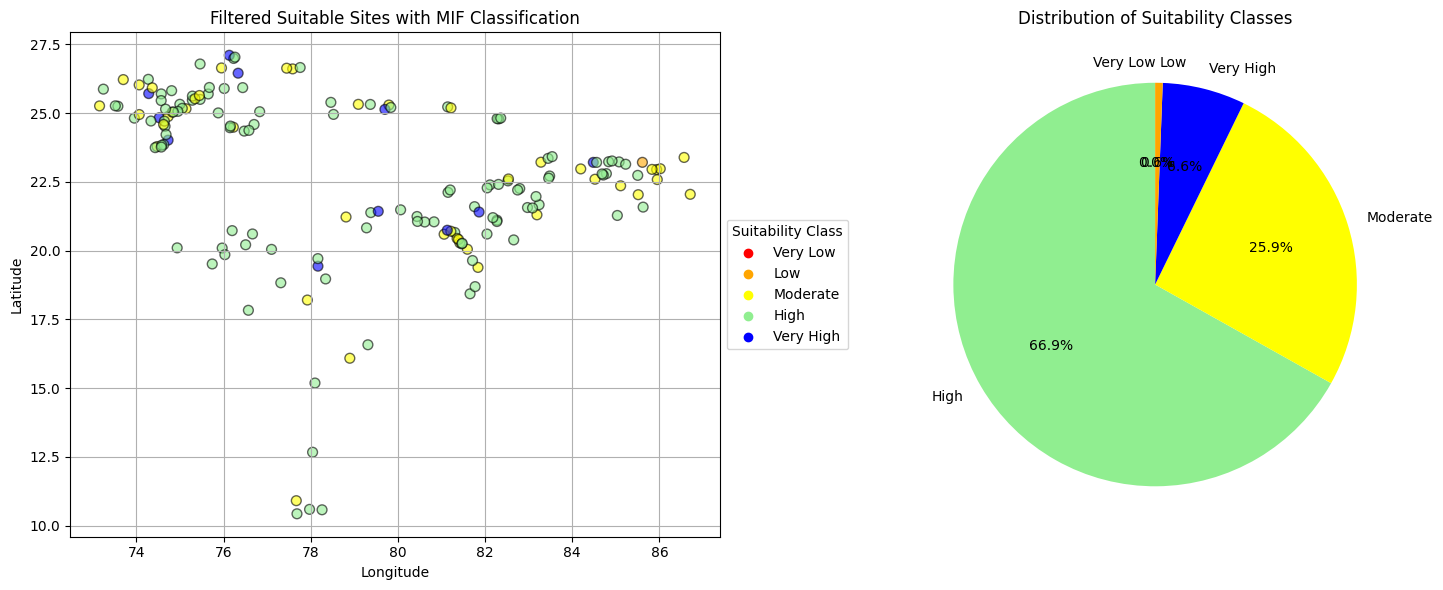

In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv(r'D:\CS\GitHub\Nuclear-Site-Selection\dam\dam.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

# Map seismicity to numeric
seismic_map = {
    'Seismic Zone-I': 1,
    'Seismic Zone-II': 2,
    'Seismic Zone-III': 3,
    'Seismic Zone-IV': 4
}
df['seismicity_numeric'] = df['dm_ses_zon'].map(seismic_map)

# ---------- Step 1: Apply Constraints (Boolean Filtering) ----------
constraints = (
    (df['Avg_population'] <= 500) &
    (df['dm_ses_zon'].isin(['Seismic Zone-I', 'Seismic Zone-II'])) &
    (df['nearest_highway_distance'] <= 5) &
    (df['distance_to_nearest_airport_km'] >= 10)
)
df['is_suitable'] = constraints

# Filter the dataset to only suitable rows
df_suitable = df[df['is_suitable']].copy()

# ---------- Step 2: Apply MIF on Suitable Subset ----------
weights = {
    'Avg_population': 0.30,
    'seismicity_numeric': 0.25,
    'nearest_highway_distance': 0.20,
    'distance_to_nearest_airport_km': 0.25
}
columns_to_normalize = list(weights.keys())

# Normalize
scaler = MinMaxScaler(feature_range=(0, 1))
df_norm = pd.DataFrame(scaler.fit_transform(df_suitable[columns_to_normalize]), columns=columns_to_normalize)

# Invert (lower is better)
df_inverted = 1 - df_norm

# Apply weights
for col in weights:
    df_inverted[col] *= weights[col]

# Compute weighted sum score
df_suitable['suitability_score'] = df_inverted.sum(axis=1)

# Optional: Classify into bins
bins = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
labels = ['Very Low', 'Low', 'Moderate', 'High', 'Very High']
df_suitable['suitability_class'] = pd.cut(
    df_suitable['suitability_score'],
    bins=bins,
    labels=labels,
    include_lowest=True,
    right=True
)
# Add colors
colors = {
    'Very Low': 'red',
    'Low': 'orange',
    'Moderate': 'yellow',
    'High': 'lightgreen',
    'Very High': 'blue'
}
df_suitable['color'] = df_suitable['suitability_class'].map(colors)

# ---------- Step 3: Plotting ----------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot of final suitable locations
scatter = ax1.scatter(df_suitable[df_suitable['suitability_class'].notna()]['dm_long'], 
                     df_suitable[df_suitable['suitability_class'].notna()]['dm_lat'],
                     c=df_suitable[df_suitable['suitability_class'].notna()]['color'], 
                     alpha=0.6, edgecolors='k', s=50)
ax1.set_title('Filtered Suitable Sites with MIF Classification')
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.grid(True)

# Legend for suitability class
legend_elements = [plt.scatter([], [], c=color, label=label) for label, color in colors.items()]
ax1.legend(handles=legend_elements, title='Suitability Class', loc='center left', bbox_to_anchor=(1, 0.5))

# Pie chart
class_counts = df_suitable['suitability_class'].value_counts()
ax2.pie(class_counts, labels=class_counts.index, colors=[colors[x] for x in class_counts.index],
        autopct='%1.1f%%', startangle=90)
ax2.set_title('Distribution of Suitability Classes')

plt.tight_layout()
plt.show()

